In [12]:
%autosave 60

Autosaving every 60 seconds


313404400.0 nan 314400000.0


(0.9968333333333333, nan)

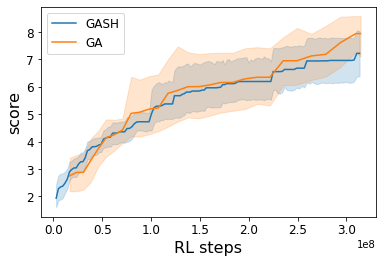

In [173]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
import seaborn as sns
from math import floor
import itertools

root_dir = os.path.dirname(Path().resolve())
root_dir=os.path.join(root_dir, 'examples')
seed=10
expr_name_normal='UpStepper-v0_TournamentGA'
expr_name_fast='UpStepper-v0_TournamentFastGA'
expr_name_suha='UpStepper-v0_TournamentSuHaGA'
expr_name_gash='UpStepper-v0_SuHaGA'
expr_name_ga='UpStepper-v0_GA'



generation=31

def gradual_increase(array):
    tmp_max=array[0]
    for i,member in enumerate(array):
        if member<tmp_max:
            array[i]=tmp_max
        else:
            tmp_max=array[i]
    return array



def max_fit_list(save_dir,generation,is_multi=False):
    fitness_gen=[]
    evaluation_list=[]
    for i in range(generation+1):
        log_dir = os.path.join(save_dir,'generation_'+str(i),'output.txt')
        with open(log_dir) as f:
            fitnesses=[]
            for line in f:
                try:
                    if is_multi:
                        fitnesses.append(float(line.split()[2]))
                    else:
                        fitnesses.append(float(line.split()[1]))
                except:
                    evaluation_list.append(int(line.split()[2]))
            if is_multi:
                evaluation_list.append(fitnesses[len(fitnesses)-1])
                del fitnesses[len(fitnesses)-1]
            fitness_gen.append(max(fitnesses))
    return gradual_increase(fitness_gen),evaluation_list

def average_graph(expr_name,seed_list,generation,is_multi):
    mat=np.empty([0,generation+1])
    for seed in seed_list:
        log_dir=expr_name+'_seed:'+str(seed)
        save_dir = os.path.join(root_dir, 'saved_data',log_dir)
        fitness_list,evaluation_list=max_fit_list(save_dir,generation,is_multi=is_multi)
        np_arr=np.array(fitness_list)[np.newaxis,:]
        mat=np.concatenate([mat,np_arr])
    data=np.average(mat,axis=0)
    return data,evaluation_list

def data_for_confidence(expr_name,seed_list,generation,is_multi,expr_type,calc_step_func,is_step_based=True):
    df=pd.DataFrame(columns=['evaluation','score'])
    for seed in seed_list:
        sub_df = pd.DataFrame(columns=['evaluation','score'])
        log_dir=expr_name+'_seed:'+str(seed)
        save_dir = os.path.join(root_dir, 'saved_data',log_dir)
        fitness_list,evaluation_list=max_fit_list(save_dir,generation,is_multi=is_multi)
        step_list=calc_step_func(save_dir,generation)
        sub_df['generation']=[i for i in range(generation+1)]
        sub_df['evaluation'] =  step_list if is_step_based else [i for i in range(generation+1)]
        sub_df['score'] = fitness_list
        df = pd.concat([df,sub_df],axis=0)
    df['type']=np.array([expr_type for i in range(len(df))])
    return df

def load_steps(save_dir,generation):
    steps_list=[]
    for i in range(generation+1):
        path=os.path.join(save_dir,'generation_'+str(i),'steps.txt')
        gen_steps=[]
        with open(path,'r') as f:
            for line in f:
                gen_steps.append(int(line.split('\t\t')[1]))
        steps_list.append(sum(gen_steps))
    accm_list=list(itertools.accumulate(steps_list))
    return np.array(accm_list)

def SH_steps(save_dir,generation):
    steps_list=[]
    for i in range(generation+1):
        this_gen_step=26200*16+52400*8+131000*4+262000*2+524000*2
        steps_list.append(this_gen_step)
    accm_list=list(itertools.accumulate(steps_list))
    return np.array(accm_list)

def normal_steps(save_dir,generation):
    steps_list=[]
    for i in range(generation+1):
        this_gen_step=524000*32
        steps_list.append(this_gen_step)
    accm_list=list(itertools.accumulate(steps_list))
    return np.array(accm_list)

                
    
# def data_for_confidence_multi(...):
# data_for_confidence()
# list
# data['hue'] = list

def calc_speedup(df,last_gen=33,last_gen_sh=145):
    df=df.reset_index()
    ga_score_df=df[(df['type']=='GA') & (df['generation']==last_gen)]
    mean_val=ga_score_df.describe().at['mean','score']
    max_eval=ga_score_df['evaluation'].mean()
    df_gash=df[(df['type']=='GASH')]
    gash_score_df=df_gash.groupby('evaluation').mean()
    score_under_length=gash_score_df[gash_score_df['score']<mean_val]
    max_gen=score_under_length['generation'].max()
    ga_step=df_gash[df_gash['generation']==max_gen]['evaluation'].mean()
    ga_step_pre=df_gash[df_gash['generation']==(max_gen+1)]['evaluation'].mean()
    print(ga_step,ga_step_pre,max_eval)
    return ga_step/max_eval,ga_step_pre/max_eval

def plot_confidence(df,is_step_based=True,name='evaluation_score'):
    df=df.reset_index()
    sns.lineplot(x="evaluation", y="score", data=df,hue='type')
    xlabel='RL steps' if is_step_based else 'generations'
    ylabel='score'
    plt.xlabel(xlabel,fontsize=16)
    plt.ylabel(ylabel,fontsize=16)
    plt.legend(fontsize=12)
    plt.tick_params(labelsize=12)
    plt.subplots_adjust(bottom=0.15)
    suffix='_step' if is_step_based else '_gen'
    plt.savefig(name+suffix+'.pdf')
    


def plot_graph(data,eval_list,label,is_eval_base=True):
    fig = plt.figure(figsize=(12, 8)) #...1
    
    # Figure内にAxesを追加()
    ax = fig.add_subplot(111) #...2
    if is_eval_base==False:
        eval_list[1]=np.array(eval_list[1])/2
    ax.plot(eval_list[1], data[1], label=label[1]) #...3
    ax.plot(eval_list[0], data[0], label=label[0]) #...3
    plt.xlabel('steps' if is_eval_base else 'evaluated design')
    plt.ylabel('score of platformjumper')
    plt.ylim([1.7,2.8])

    # 凡例の表示
    plt.legend()

    # プロット表示(設定の反映)
    plt.show()


        
    
    
expr_name_normal='UpStepper-v0_TournamentGA'
expr_name_fast='UpStepper-v0_TournamentFastGA'
expr_name_suha='UpStepper-v0_TournamentSuHaGA'
expr_name_gash='UpStepper-v0_SuHaGA'
expr_name_ga='UpStepper-v0_GA'
expr_name_scaleSuHA='UpStepper-v0_scaleSuHaGA'
is_step_based=True

#data_normal,eval_list_normal=average_graph(expr_name_normal,[0,100,6,9],31,False)
#data_fast,eval_list_fast=average_graph(expr_name_fast,[6,7,8,9,10,11,12,13,14,15],31,False)
#df_normal=data_for_confidence(expr_name_normal,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],31,False,'normal',normal_steps)
#df_fast=data_for_confidence(expr_name_fast,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],31,False,'fast',SH_steps,is_step_based)
#df_suha=data_for_confidence(expr_name_suha,range(15),187,False,'SH',SH_steps)
df_gash=data_for_confidence(expr_name_gash,[2,3,5,6,7,8,10,11,12,13],133,False,'GASH',load_steps,is_step_based)
df_ga=data_for_confidence(expr_name_ga,[0,1,2,3,4,6,7],28,False,"GA",load_steps,is_step_based)
df_scaleSH=data_for_confidence(expr_name_scaleSuHA,[3,4,5,6,7,8],27,False,"scaleSHGA",load_steps,is_step_based)

#df_ga=data_for_confidence()
#df_normal.head(5)
plot_confidence(pd.concat([df_gash,df_ga]),is_step_based,'UpStepper-v0')
#calc_speedup(pd.concat([df_gash,df_ga]),last_gen=28,last_gen_sh=133)

#plot_graph([data_single,data_multi],[eval_list_single,eval_list_multi],['GA:4 seed average','multi:5 seed average'])

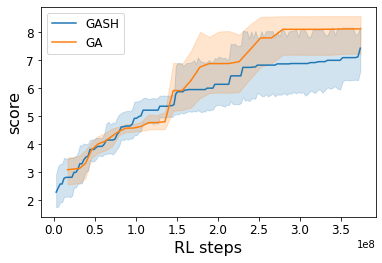

In [74]:
is_step_based=True
df_gash=data_for_confidence('UpStepper-v0_SuHaGA',[101,102,103,104,105,106,107],145,False,'GASH',load_steps,is_step_based)
df_ga=data_for_confidence('UpStepper-v0_GA',[101,102,103,104,105,106,107],33,False,"GA",load_steps,is_step_based)
plot_confidence(pd.concat([df_gash,df_ga]),is_step_based,'UpStepper-v0')

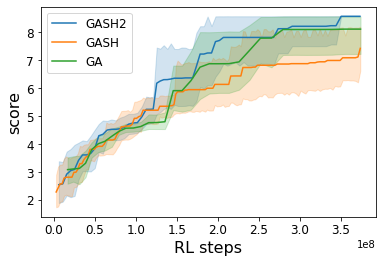

In [199]:
is_step_based=True
df_gash_2=data_for_confidence('UpStepper-v0_SuHatrain_scale2_GA',[101,102,103,104,105,106,107],72,False,'GASH2',load_steps,is_step_based)
df_gash=data_for_confidence('UpStepper-v0_SuHaGA',[101,102,103,104,105,106,107],145,False,'GASH',load_steps,is_step_based)
df_ga=data_for_confidence('UpStepper-v0_GA',[101,102,103,104,105,106,107],33,False,"GA",load_steps,is_step_based)
plot_confidence(pd.concat([df_gash_2,df_gash,df_ga]),is_step_based,'UpStepper-v0_scale2')

503008128.0 505574496.0 758564352.0


(0.6631054131054132, 0.666488603988604)

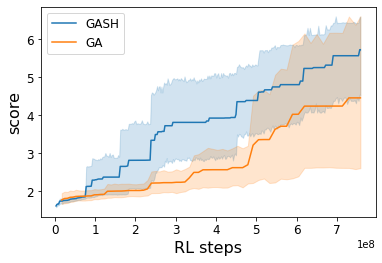

In [160]:
is_step_based=True
df_gash=data_for_confidence('PlatformJumper-v0_SuHaGA',[101,102,103,104,105,106,107],293,False,'GASH',load_steps,is_step_based)
df_ga=data_for_confidence('PlatformJumper-v0_GA',[101,102,103,104,105,106,107],67,False,"GA",load_steps,is_step_based)
plot_confidence(pd.concat([df_gash,df_ga]),is_step_based,'PlatformJumper-v0')
calc_speedup(pd.concat([df_gash,df_ga]),last_gen=67,last_gen_sh=293)

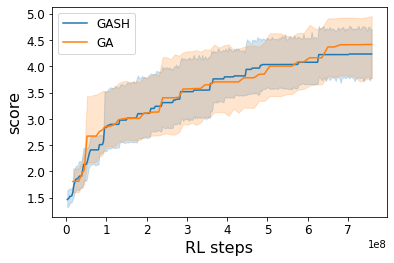

In [78]:
is_step_based=True
df_gash=data_for_confidence('ObstacleTraverser-v1_SuHaGA',[101,102,103,104,105,106,107],293,False,'GASH',load_steps,is_step_based)
df_ga=data_for_confidence('ObstacleTraverser-v1_GA',[101,102,103,104,105,106,107],67  ,False,"GA",load_steps,is_step_based)
plot_confidence(pd.concat([df_gash,df_ga]),is_step_based,'ObstacleTraverser-v1')

186838344.0 189134568.0 378201600.0


(0.4940178571428571, 0.5000892857142857)

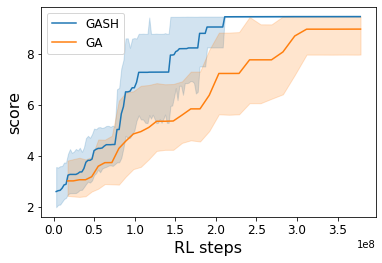

In [161]:
is_step_based=True
df_gash=data_for_confidence('ObstacleTraverser-v0_SuHaGA',[101,102,103,104,105,106,107],145,False,'GASH',load_steps,is_step_based)
df_ga=data_for_confidence('ObstacleTraverser-v0_GA',[101,102,103,104,105,106,107],33,False,"GA",load_steps,is_step_based)
plot_confidence(pd.concat([df_gash,df_ga]),is_step_based,'ObstacleTraverser-v0')
calc_speedup(pd.concat([df_gash,df_ga]),last_gen=33,last_gen_sh=145)

225534312.0 228036912.0 373721600.0


(0.6034821428571429, 0.6101785714285715)

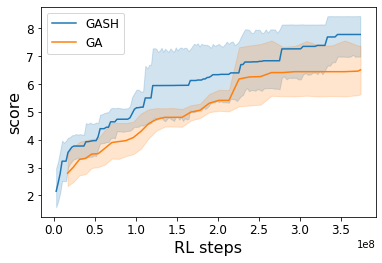

In [162]:
is_step_based=True
df_gash=data_for_confidence('UpStepper-v0_SuHa8*8GA',[101,102,103,104,105,106,107],145,False,'GASH',load_steps,is_step_based)
df_ga=data_for_confidence('UpStepper-v0_8*8GA',[101,102,103,104,105,106,107],33,False,"GA",load_steps,is_step_based)
plot_confidence(pd.concat([df_gash,df_ga]),is_step_based,'UpStepper-v0_8*8')
calc_speedup(pd.concat([df_gash,df_ga]),last_gen=33,last_gen_sh=145)

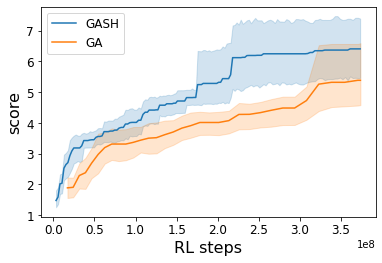

In [91]:
is_step_based=True
df_gash=data_for_confidence('UpStepper-v0_SuHa10*10GA',[101,102,103,104,105,106,107],145,False,'GASH',load_steps,is_step_based)
df_ga=data_for_confidence('UpStepper-v0_10*10GA',[101,102,103,104,105,106],33,False,"GA",load_steps,is_step_based)
plot_confidence(pd.concat([df_gash,df_ga]),is_step_based,'UpStepper-v0_10*10')

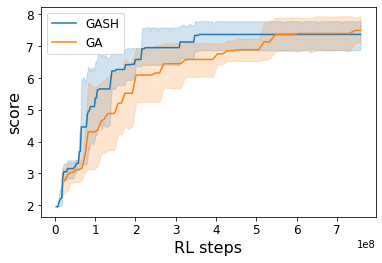

In [164]:
is_step_based=True
df_gash=data_for_confidence('GapJumper-v0_SuHaGA',[101,102,103,104,105],293,False,'GASH',load_steps,is_step_based)
df_ga=data_for_confidence('GapJumper-v0_GA',[101,102,103,104,105],67  ,False,"GA",load_steps,is_step_based)
plot_confidence(pd.concat([df_gash,df_ga]),is_step_based,'GapJumper-v0')

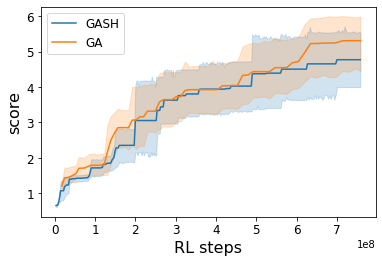

In [85]:
is_step_based=True
df_gash=data_for_confidence('Hurdler-v0_SuHaGA',[101,102,103,104,105],293,False,'GASH',load_steps,is_step_based)
df_ga=data_for_confidence('Hurdler-v0_GA',[101,102,103,104,105,106],67,False,"GA",load_steps,is_step_based)
plot_confidence(pd.concat([df_gash,df_ga]),is_step_based,'Hurdler-v0')

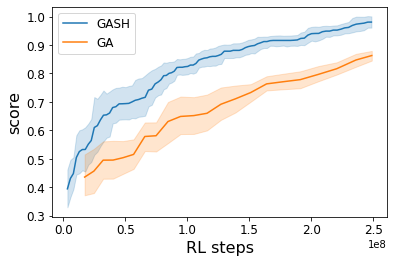

In [189]:
is_step_based=True
df_gash=data_for_confidence('WingspanMazimizer-v0_SuHaGA',[101,102,103,104,105,106,107],96,False,'GASH',load_steps,is_step_based)
df_ga=data_for_confidence('WingspanMazimizer-v0_GA',[101,102,103,104,105,106,107],21,False,"GA",load_steps,is_step_based)
plot_confidence(pd.concat([df_gash,df_ga]),is_step_based,'WingspanMazimizer-v0')

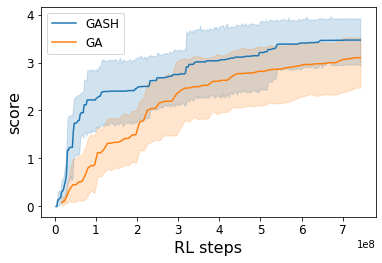

In [191]:
is_step_based=True
df_gash=data_for_confidence('Lifter-v0_SuHaGA',[101,102,103,104,105,106,107],293,False,'GASH',load_steps,is_step_based)
df_ga=data_for_confidence('Lifter-v0_GA',[101,102,103,104,105,106,107],67,False,"GA",load_steps,is_step_based)
plot_confidence(pd.concat([df_gash,df_ga]),is_step_based,'Lifter-v0')

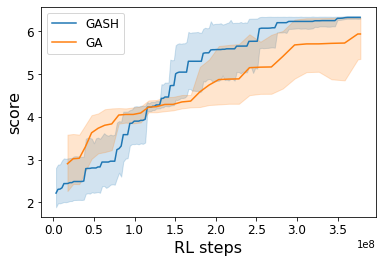

In [195]:
is_step_based=True
df_gash=data_for_confidence('CaveCrawler-v0_SuHaGA',[101,102,103,104,105,106,107],145,False,'GASH',load_steps,is_step_based)
df_ga=data_for_confidence('CaveCrawler-v0_GA',[101,102,103,104,105,106,107],33,False,"GA",load_steps,is_step_based)
plot_confidence(pd.concat([df_gash,df_ga]),is_step_based,'CaveCrawler-v0')

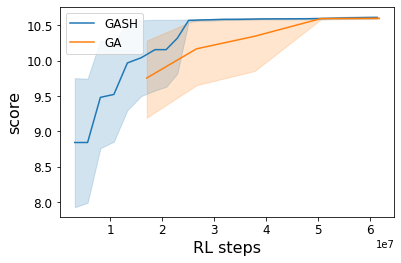

In [196]:
is_step_based=True
df_gash=data_for_confidence('Walker-v0_SuHaGA',[101,102,103,104,105,106,107],23,False,'GASH',load_steps,is_step_based)
df_ga=data_for_confidence('Walker-v0_GA',[101,102,103,104,105,106,107],4,False,"GA",load_steps,is_step_based)
plot_confidence(pd.concat([df_gash,df_ga]),is_step_based,'Walker-v0')

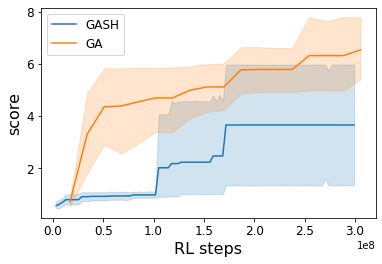

In [180]:
is_step_based=True
df_cppnsh=data_for_confidence('Climber-v0_SuHacppn',[101,102,103,104,105],93,False,'GASH',load_steps,is_step_based)
df_cppn=data_for_confidence('Climber-v0_cppn',[101,102,103,104,106,107],17,False,'GA',load_steps,is_step_based)
plot_confidence(pd.concat([df_cppnsh,df_cppn]),is_step_based,'Climber-v0_cppn')

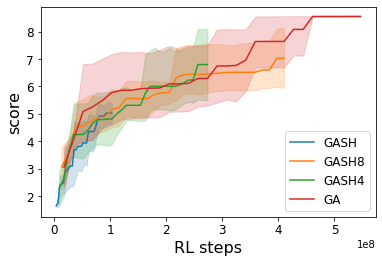

In [168]:
is_step_based=True
df_gash=data_for_confidence('UpStepper-v0_TournamentSuHaGA',[101,102,103,104,105],31,False,'GASH',load_steps,is_step_based)
df_gash8=data_for_confidence('UpStepper-v0_Tournamentscale8_SuHaGA',[101,102,103,104,105],31,False,'GASH8',load_steps,is_step_based)
df_gash4=data_for_confidence('UpStepper-v0_Tournamentscale4_SuHaGA',[101,102,103,104,105],31,False,'GASH4',load_steps,is_step_based)
df_ga=data_for_confidence('UpStepper-v0_TournamentGA',[101,102,103,104,105],31,False,"GA",load_steps,is_step_based)
plot_confidence(pd.concat([df_gash,df_gash8,df_gash4,df_ga]),is_step_based,'UpStepper-v0_TournamentGA')

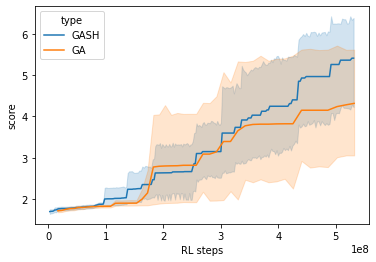

In [132]:
is_step_based=True
df_gash=data_for_confidence('PlatformJumper-v0_SuHaGA',[1,2,3,4,6,7,8,9],223,False,'GASH',load_steps,is_step_based)
df_ga=data_for_confidence('PlatformJumper-v0_GA',[1,2,3,4,5,6,7,8,9],47,False,"GA",load_steps,is_step_based)
plot_confidence(pd.concat([df_gash,df_ga]),is_step_based,'PlatformJumper-v0')

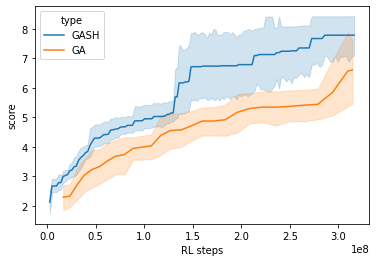

In [24]:
is_step_based=True
df_gash=data_for_confidence('UpStepper-v0_SuHa8*8GA',[0,2,3,4,5,6,7],134,False,'GASH',load_steps,is_step_based)
df_ga=data_for_confidence('UpStepper-v0_8*8GA',[0,2,3,4,5,6,7],28,False,"GA",load_steps,is_step_based)

plot_confidence(pd.concat([df_gash,df_ga]),is_step_based,'UpStepper-v0_8*8')

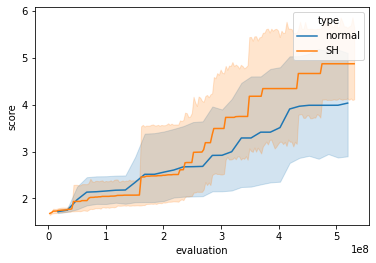

In [5]:
expr_name_normal='PlatformJumper-v0_TournamentGA'
expr_name_suha='PlatformJumper-v0_TournamentSuHaGA'
df_normal=data_for_confidence(expr_name_normal,[0,1,2,3,4,5,6,10,20],30,False,'normal',normal_steps)
df_suha=data_for_confidence(expr_name_suha,[0,1,3,5,6,9,10],180,False,'SH',SH_steps)
plot_confidence(pd.concat([df_normal,df_suha]))

In [120]:
from utils.algo_utils import *

def calc_step_from_evaluated(evaluated):
    step=0
    eval_timing_arr=[1,2,4,8,16]
    n=math.ceil(math.log2(evaluated))
    pre_index=5-n
    for i in range(n):
        next_evaluated=math.ceil(evaluated/2.0) if evaluated>2 else 0
        step+=eval_timing_arr[pre_index+i]*(evaluated-next_evaluated)
        evaluated=next_evaluated
    return step

def calc_max_evaluations_in_GA(total_step):
    return total_step/16


def calc_step_from_evaluations(max_evaluations):
    total_step=0
    gen=0
    pop_size=32
    num_evaluations=0
    num_survivors=0
    
    while True:
        num_evaluated=pop_size-num_survivors
        if (num_evaluations+num_evaluated) > max_evaluations:
            num_evaluated=max_evaluations-num_evaluations
        num_evaluations+=num_evaluated
        total_step+=calc_step_from_evaluated(num_evaluated)
        
        if num_evaluations == max_evaluations:
            break
        
        percent_survival = get_percent_survival_evals(num_evaluations, max_evaluations)
        num_survivors = max(2, math.ceil(pop_size * percent_survival))
        gen+=1
    
    print(gen,num_evaluations,total_step,calc_max_evaluations_in_GA(total_step))
    
    return calc_max_evaluations_in_GA(total_step)
        
    

calc_step_from_evaluations(6000)

293 6000 22456 1403.5


1403.5

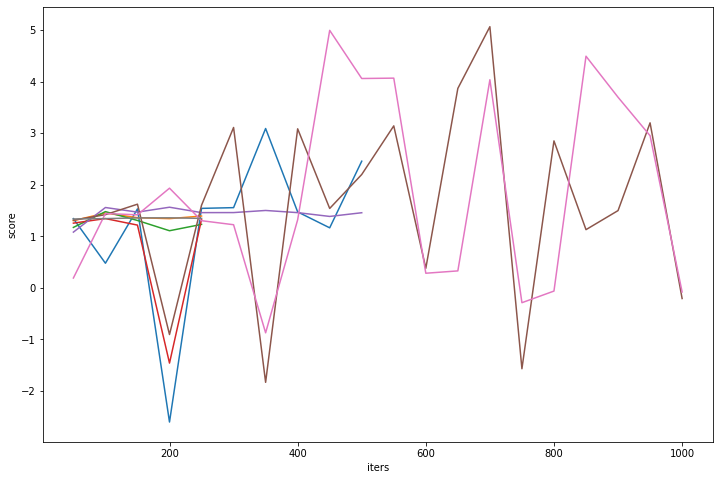

{'4667': ['1.342294', '0.477501', '1.531324', '-2.603137', '1.541826', '1.555907', '3.090995', '1.472981', '1.164232', '2.456728\n'], '4665': ['1.303401', '1.450753', '1.360503', '1.342563', '1.392771\n'], '4653': ['1.172378', '1.478577', '1.307008', '1.107966', '1.230932\n'], '4642': ['1.255221', '1.343619', '1.217252', '-1.459688', '1.32654\n'], '4659': ['1.08097', '1.558401', '1.469075', '1.564118', '1.459252', '1.460111', '1.501131', '1.459012', '1.385374', '1.457027\n'], '4668': ['1.312711', '1.419564', '1.622866', '-0.905658', '1.602538', '3.111026', '-1.832879', '3.085028', '1.540236', '2.198899', '3.142076', '0.379293', '3.869001', '5.066225', '-1.569412', '2.850668', '1.128978', '1.498647', '3.200851', '-0.207124\n'], '4648': ['0.190735', '1.442051', '1.416535', '1.933477', '1.302716', '1.224366', '-0.87239', '1.320619', '4.994863', '4.060916', '4.068167', '0.283415', '0.328798', '4.036918', '-0.288106', '-0.06249', '4.493434', '3.697689', '2.951491', '-0.08011\n'], '4652': ['

In [115]:
import matplotlib.pyplot as plt
expr_name='UpStepper-v0_TournamentSuHaGA'
seed=5
expr_name+='_seed:'+str(seed)
gen=145

fig = plt.figure(figsize=(12, 8)) #...1
ax = fig.add_subplot(111) #...2
# Figure内にAxesを追加()


evals=['_250','_500','']
index_score_dict={}
for eval_str in evals:
    path=os.path.join(root_dir,'saved_data',expr_name,'generation_'+str(gen),'eval_history'+str(eval_str)+'.txt')
    with open(path) as f:
        for line in f:
            index_score_dict[line.split('\t\t')[0]]=line.split('\t\t')[1:]
            
for key in index_score_dict:
    data=[float(score.split('\n')[0]) for score in index_score_dict[key]]
    eval_list=[(i+1)*50 for i in range(len(index_score_dict[key]))]
    
    ax.plot(eval_list,data)
    
plt.xlabel('iters')
plt.ylabel('score')
plt.savefig('eval_hist.pdf')
plt.show()
print(index_score_dict)
val_list=[64,128,256,512,1024]

def plot_graph(data,eval_list,label,is_eval_base=True):
    fig = plt.figure(figsize=(12, 8)) #...1
    
    # Figure内にAxesを追加()
    ax = fig.add_subplot(111) #...2
    if is_eval_base==False:
        eval_list[1]=np.array(eval_list[1])/2
    ax.plot(eval_list[1], data[1], label=label[1]) #...3
    ax.plot(eval_list[0], data[0], label=label[0]) #...3
    plt.xlabel('steps' if is_eval_base else 'evaluated design')
    plt.ylabel('score of platformjumper')
    plt.ylim([1.7,2.8])

    # 凡例の表示
    plt.legend()

    #  プロット表示(設定の反映)
    plt.show()